# Web Attack Payload Detection using RNN

This notebook implements a Recurrent Neural Network (RNN) model to detect web attack payloads in HTTP requests. The model analyzes request metadata (Method, URL, cookies, etc.) to classify requests as **Normal** or **Attack** (SQL injection, XSS, etc.).

## Dataset
We use the **CSIC 2010 HTTP Dataset** containing labeled HTTP requests for web attack detection.

## Workflow
1. **Data Loading & Exploration** - Load and understand the dataset
2. **Data Preprocessing** - Clean, encode, and normalize features
3. **Model Training** - Train an RNN classifier
4. **Model Export** - Export to ONNX for deployment
5. **API Testing** - Validate the exported model

## 1. Import Libraries

Import necessary libraries for data processing, visualization, and deep learning.

In [1]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle

# Deep Learning - Keras/TensorFlow
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# PyTorch (for ONNX export)
import torch
import torch.nn as nn

# ONNX Runtime
import onnxruntime as ort
import onnx

print(f"TensorFlow: {tf.__version__}")
print(f"PyTorch: {torch.__version__}")

TensorFlow: 2.20.0
PyTorch: 2.9.1+cpu


## 2. Data Loading & Exploration

Load the CSIC HTTP dataset and explore its structure.

In [2]:
# Load the dataset
df = pd.read_csv('csic_database.csv', on_bad_lines='skip')

# Rename the unnamed column to 'Class' (contains Normal/Anomalous labels)
df.rename(columns={'Unnamed: 0': 'Class'}, inplace=True)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (61065, 17)

Columns: ['Class', 'Method', 'User-Agent', 'Pragma', 'Cache-Control', 'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host', 'cookie', 'content-type', 'connection', 'lenght', 'content', 'classification', 'URL']


,Class,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


### 2.1 Dataset Statistics

Examine the class distribution and data types.

Normal requests:  36,000 (59.0%)
Attack requests:  25,065 (41.0%)
Total requests:   61,065


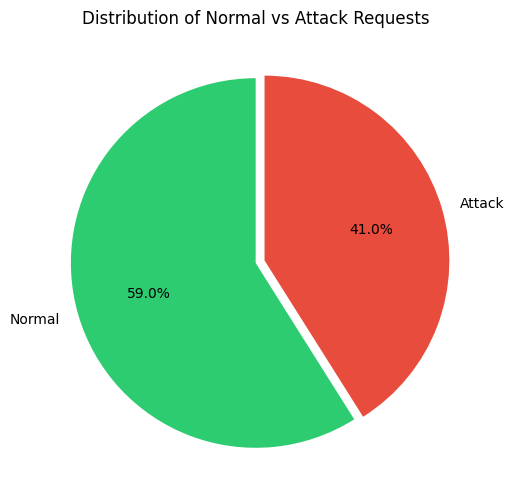

In [3]:
# Calculate class distribution
class_counts = df['Class'].value_counts()
normal_count = class_counts.get('Normal', 0)
anomaly_count = class_counts.get('Anomalous', 0)

print(f"Normal requests:  {normal_count:,} ({normal_count/len(df)*100:.1f}%)")
print(f"Attack requests:  {anomaly_count:,} ({anomaly_count/len(df)*100:.1f}%)")
print(f"Total requests:   {len(df):,}")

# Visualize class distribution
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['#2ecc71', '#e74c3c']
ax.pie([normal_count, anomaly_count], labels=['Normal', 'Attack'], 
       colors=colors, autopct='%1.1f%%', startangle=90, explode=(0, 0.05))
ax.set_title('Distribution of Normal vs Attack Requests')
plt.show()

## 3. Data Preprocessing

### 3.1 Data Cleaning
- Remove columns with only single unique values (no predictive power)
- Handle missing values
- **Important**: Remove the `classification` column as it contains the label (data leakage!)

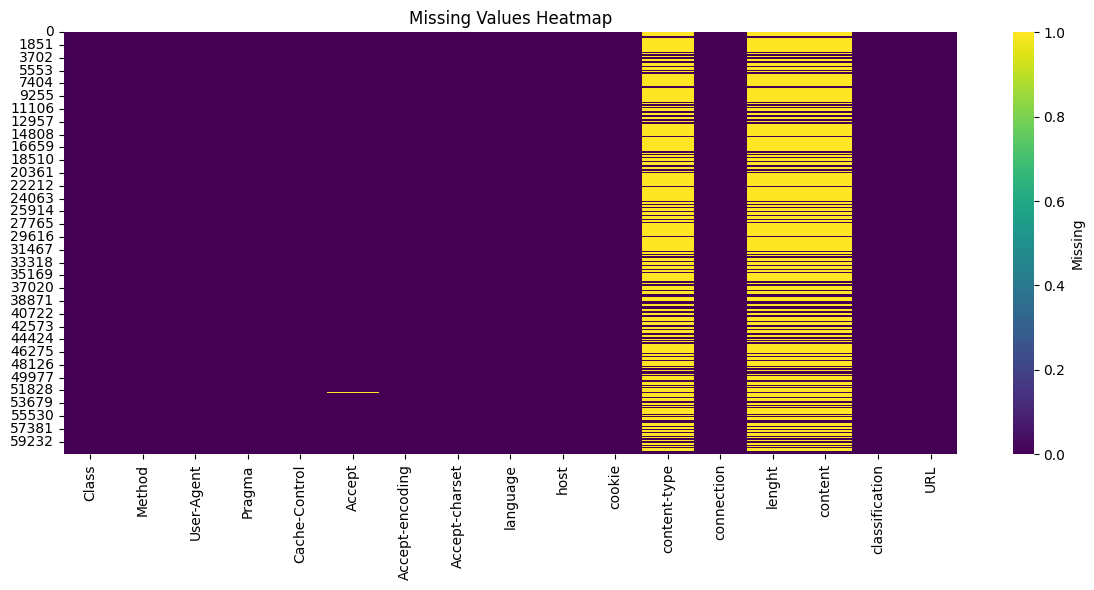


Missing values per column:
Accept            397
content-type    43088
lenght          43088
content         43088
dtype: int64


In [4]:
# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar_kws={'label': 'Missing'})
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

print(f"\nMissing values per column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

In [5]:
# Find and remove single-value columns (no predictive power)
single_value_cols = [col for col in df.columns if df[col].nunique() == 1]
print(f"Columns with single value (will be removed): {single_value_cols}")

df = df.drop(single_value_cols, axis=1)

# IMPORTANT: Remove 'classification' column - it's the label encoded as 0/1 (data leakage!)
if 'classification' in df.columns:
    df = df.drop('classification', axis=1)
    print("Removed 'classification' column (data leakage)")

print(f"\nRemaining columns ({len(df.columns)}): {df.columns.tolist()}")

Columns with single value (will be removed): ['User-Agent', 'Pragma', 'Cache-Control', 'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'content-type']
Removed 'classification' column (data leakage)

Remaining columns (8): ['Class', 'Method', 'host', 'cookie', 'connection', 'lenght', 'content', 'URL']


### 3.2 Feature Encoding

Convert categorical features to numerical values using Ordinal Encoding.

In [6]:
# Encode all columns using OrdinalEncoder
enc = OrdinalEncoder()
for column in df.columns:
    df[column] = enc.fit_transform(df[[column]])

# Fill missing values with column means
df['lenght'] = df['lenght'].fillna(df['lenght'].mean())
df['content'] = df['content'].fillna(df['content'].mean())

print("Data after encoding:")
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
df.head()

Data after encoding:
Shape: (61065, 8)
Missing values: 0


,Class,Method,host,cookie,connection,lenght,content,URL
0,1.0,0.0,0.0,7623.0,1.0,220.083051,4234.348612,800.0
1,1.0,0.0,0.0,31127.0,1.0,220.083051,4234.348612,5503.0
2,1.0,1.0,0.0,35218.0,0.0,333.000000,2190.000000,3578.0
3,1.0,0.0,0.0,34368.0,1.0,220.083051,4234.348612,6381.0
4,1.0,1.0,0.0,27185.0,0.0,324.000000,3137.000000,5840.0


### 3.3 Feature Normalization

Apply Z-score normalization to scale features to have zero mean and unit variance.

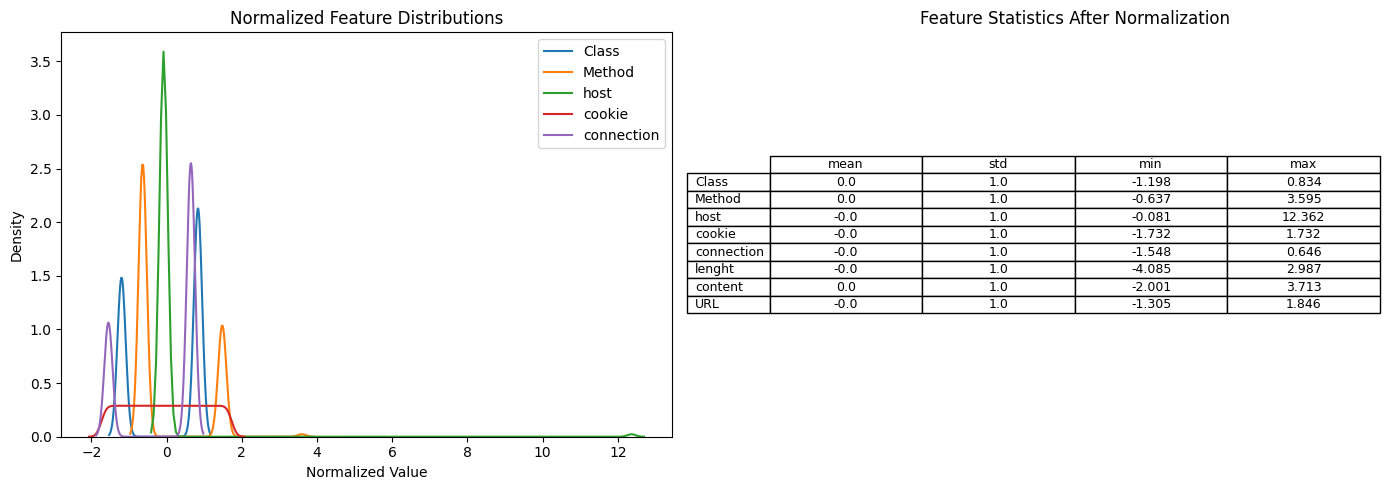

In [7]:
# Apply Z-score normalization: (x - mean) / std
for column in df.columns:
    mean_val = df[column].mean()
    std_val = df[column].std()
    if std_val > 0:
        df[column] = (df[column] - mean_val) / std_val

# Visualize normalized data distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before vs After comparison (sample)
axes[0].set_title("Normalized Feature Distributions")
for col in df.columns[:5]:
    sns.kdeplot(df[col], ax=axes[0], label=col)
axes[0].legend()
axes[0].set_xlabel("Normalized Value")

# Show statistics
stats_df = df.describe().T[['mean', 'std', 'min', 'max']]
axes[1].axis('off')
axes[1].set_title("Feature Statistics After Normalization")
table = axes[1].table(cellText=stats_df.round(3).values,
                       colLabels=stats_df.columns,
                       rowLabels=stats_df.index,
                       cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)

plt.tight_layout()
plt.show()

### 3.4 Feature Correlation Analysis

Analyze correlations between features to understand relationships and potential multicollinearity.

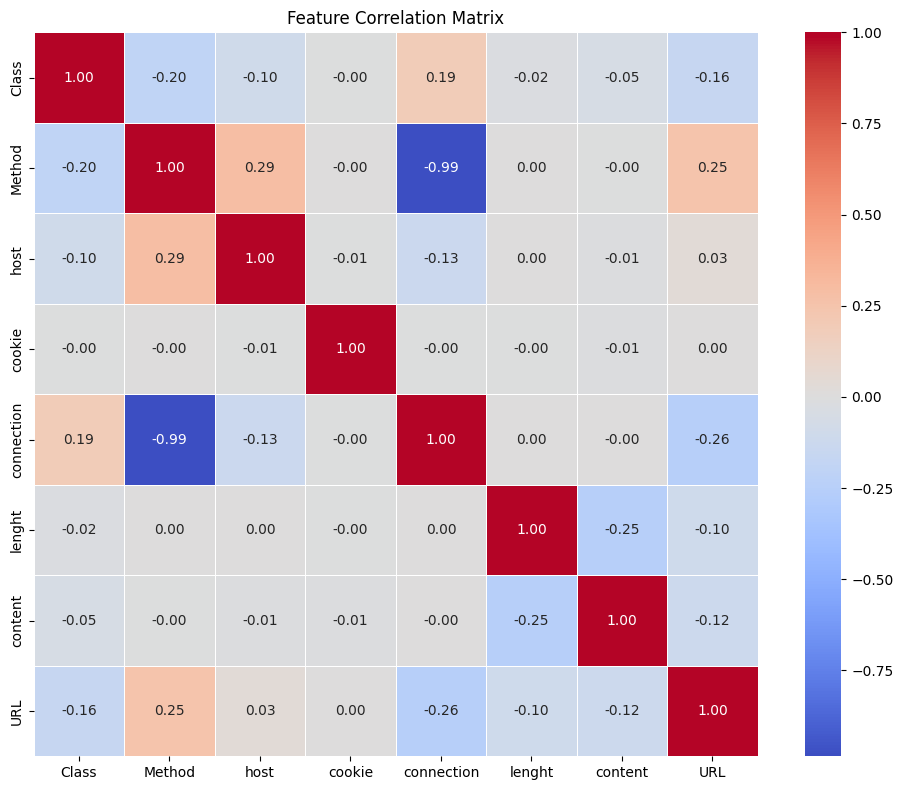

In [8]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# Note: Low correlations between features suggest each captures unique information

## 4. Model Training

### 4.1 Data Preparation

Prepare train/test split and reshape data for RNN input format `(samples, timesteps, features)`.

In [9]:
# Shuffle and prepare data
data = shuffle(df.copy())

# Encode target labels (Normal=0, Attack=1)
encoder = LabelEncoder()
data['Class'] = encoder.fit_transform(data['Class'])

# Split features and target
X = data.drop('Class', axis=1)
y = data['Class']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Class distribution - Train: {y_train.value_counts().to_dict()}")
print(f"Class distribution - Test: {y_test.value_counts().to_dict()}")

Training samples: 48852
Testing samples: 12213
Number of features: 7
Class distribution - Train: {1: 28713, 0: 20139}
Class distribution - Test: {1: 7287, 0: 4926}


### 4.2 Model Architecture

Build a Simple RNN classifier with:
- **SimpleRNN layer**: 32 units with ReLU activation (captures sequential patterns)
- **Dropout layers**: 20% dropout for regularization
- **Dense layers**: 64 hidden units → 1 output (sigmoid for binary classification)

In [10]:
# Build RNN model
model_rnn = Sequential([
    SimpleRNN(units=32, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.summary()

c:\Users\jnz\Documents\webattack-payload-detector\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

### 4.3 Training with Early Stopping

Train the model with:
- **Early stopping**: Stop if validation accuracy doesn't improve for 3 epochs
- **Model checkpointing**: Save the best model based on validation accuracy
- **Validation split**: 20% of training data for validation

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Reshape data for RNN: (samples, timesteps=features, channels=1)
X_train_rnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Callbacks
checkpoint = ModelCheckpoint(
    "models/simple_rnn_fixed.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)
early_stop = EarlyStopping(
    patience=3,
    restore_best_weights=True,
    monitor="val_accuracy",
    mode="max"
)

# Train
history = model_rnn.fit(
    X_train_rnn, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/20
1196/1222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6287 - loss: 0.6454
Epoch 1: val_accuracy improved from None to 0.66749, saving model to models/simple_rnn_fixed.keras
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6436 - loss: 0.6319 - val_accuracy: 0.6675 - val_loss: 0.6039
Epoch 2/20
1200/1222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6542 - loss: 0.6130
Epoch 2: val_accuracy did not improve from 0.66749
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6568 - loss: 0.6112 - val_accuracy: 0.6660 - val_loss: 0.5957
Epoch 3/20
1199/1222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6634 - loss: 0.6021
Epoch 3: val_accuracy improved from 0.66749 to 0.67086, saving model to models/simple_rnn_fixed.keras
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6646 - loss: 0.6011 - val_accuracy: 0.6709 - val_loss: 0.5872
Epoch 4/20
1209/1222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6653 - loss: 0.5991
Epoch 4: val_accuracy improved from 0.6

382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
Test Accuracy: 0.7389

Classification Report:
              precision    recall  f1-score   support

      Normal       0.72      0.58      0.64      4926
      Attack       0.75      0.85      0.79      7287

    accuracy                           0.74     12213
   macro avg       0.73      0.71      0.72     12213
weighted avg       0.74      0.74      0.73     12213



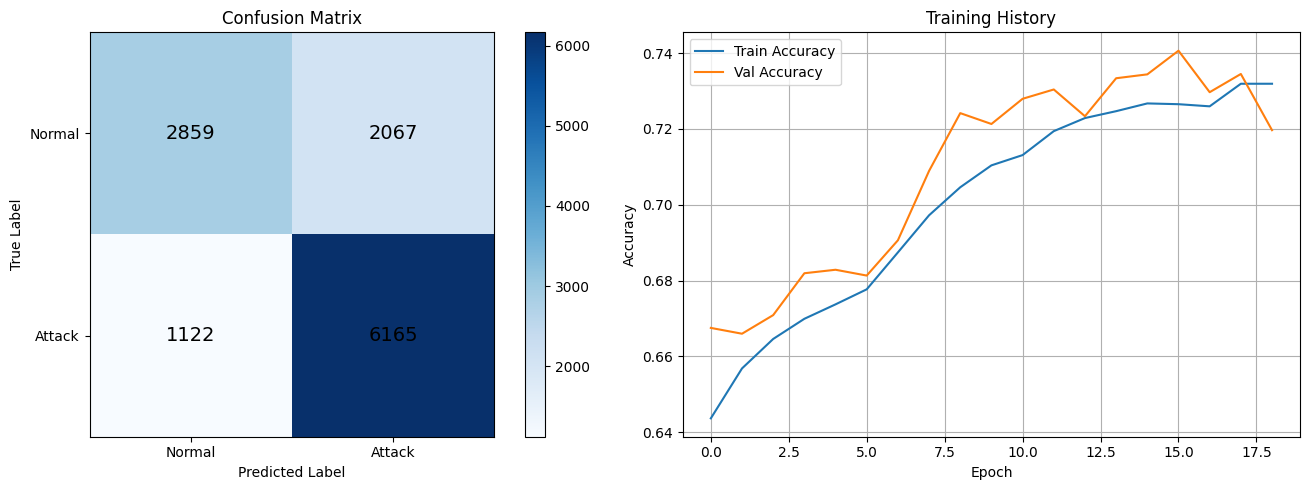

In [12]:
### 4.4 Model Evaluation

# Evaluate on test set
test_predictions = np.round(model_rnn.predict(X_test_rnn)).flatten()
test_accuracy = accuracy_score(y_test, test_predictions)
test_confusion = confusion_matrix(y_test, test_predictions)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, test_predictions, target_names=['Normal', 'Attack']))

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
im = axes[0].imshow(test_confusion, cmap=plt.cm.Blues)
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["Normal", "Attack"])
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(["Normal", "Attack"])
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, test_confusion[i, j], ha="center", va="center", fontsize=14)
plt.colorbar(im, ax=axes[0])

# Training History
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title("Training History")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 5. ONNX Export

Export the trained Keras model to ONNX format for deployment. Since `tf2onnx` is incompatible with Python 3.13/TensorFlow 2.20, we use PyTorch as an intermediate step:

1. Copy Keras weights to equivalent PyTorch model
2. Export PyTorch model to ONNX
3. Verify predictions match between Keras, PyTorch, and ONNX

### 5.1 PyTorch Model Definition

In [13]:
import torch
import torch.nn as nn

class SimpleRNNExporter(nn.Module):
    """
    PyTorch equivalent of Keras SimpleRNN for ONNX export.
    
    Key: Use nonlinearity='relu' to match Keras SimpleRNN(activation='relu')
    """
    def __init__(self, input_size, hidden_size=32, dense_size=64):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size, 
            hidden_size=hidden_size,
            batch_first=True, 
            nonlinearity='relu'  # Must match Keras activation
        )
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(dense_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Take last timestep output
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

print("PyTorch model class defined successfully")

PyTorch model class defined successfully


### 5.2 Weight Transfer and ONNX Export

Transfer Keras weights to PyTorch model and export to ONNX format.

In [14]:
# Load trained Keras model
model_keras = tf.keras.models.load_model("models/simple_rnn_fixed.keras")

# Create PyTorch model and copy weights
pytorch_model = SimpleRNNExporter(input_size=1, hidden_size=32, dense_size=64)
keras_weights = model_keras.get_weights()

print("Transferring Keras weights to PyTorch:")
print("  Keras weights:", [w.shape for w in keras_weights])

with torch.no_grad():
    # RNN layer: Keras [input_kernel, recurrent_kernel, bias] -> PyTorch [weight_ih, weight_hh, bias_ih]
    pytorch_model.rnn.weight_ih_l0.copy_(torch.tensor(keras_weights[0].T))
    pytorch_model.rnn.weight_hh_l0.copy_(torch.tensor(keras_weights[1].T))
    pytorch_model.rnn.bias_ih_l0.copy_(torch.tensor(keras_weights[2]))
    pytorch_model.rnn.bias_hh_l0.zero_()  # Keras combines biases, PyTorch splits them
    
    # Dense layers
    pytorch_model.fc1.weight.copy_(torch.tensor(keras_weights[3].T))
    pytorch_model.fc1.bias.copy_(torch.tensor(keras_weights[4]))
    pytorch_model.fc2.weight.copy_(torch.tensor(keras_weights[5].T))
    pytorch_model.fc2.bias.copy_(torch.tensor(keras_weights[6]))

pytorch_model.eval()

# Export to ONNX
dummy_input = torch.randn(1, 7, 1)  # 7 features
torch.onnx.export(
    pytorch_model, 
    dummy_input, 
    "models/simple_rnn_fixed.onnx",
    export_params=True,
    opset_version=14,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}},
    dynamo=False
)

# Verify ONNX file
import onnx
onnx.checker.check_model(onnx.load("models/simple_rnn_fixed.onnx"))
print("✓ ONNX model exported and validated: models/simple_rnn_fixed.onnx")

Transferring Keras weights to PyTorch:
  Keras weights: [(1, 32), (32, 32), (32,), (32, 64), (64,), (64, 1), (1,)]


C:\Users\jnz\AppData\Local\Temp\ipykernel_10200\3610680287.py:28: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
c:\Users\jnz\Documents\webattack-payload-detector\.venv\Lib\site-packages\torch\onnx\_internal\torchscript_exporter\symbolic_opset9.py:4247: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with RNN_RELU can cause an error when running the ONNX model with a different batch size. Make sure

✓ ONNX model exported and validated: models/simple_rnn_fixed.onnx


### 5.3 Verification

Verify that all three model formats (Keras, PyTorch, ONNX) produce identical predictions.

In [15]:
import onnxruntime as ort

# Load ONNX model
onnx_session = ort.InferenceSession("models/simple_rnn_fixed.onnx")

# Test with sample input (normalized features)
test_features = np.array([[-0.6366, -0.0809, -1.2996, 0.6459, 0.0, 0.0, -1.1179]], dtype=np.float32)
test_input = test_features.reshape(1, 7, 1)

# Get predictions from all three formats
keras_pred = model_keras.predict(test_input, verbose=0)[0][0]

pytorch_input = torch.tensor(test_input)
with torch.no_grad():
    pytorch_pred = pytorch_model(pytorch_input).item()

onnx_pred = onnx_session.run(None, {'input': test_input})[0][0][0]

print("Model Prediction Verification")
print("=" * 50)
print(f"Keras:   {keras_pred:.6f}")
print(f"PyTorch: {pytorch_pred:.6f}")
print(f"ONNX:    {onnx_pred:.6f}")
print(f"\nMax diff: {max(abs(keras_pred - pytorch_pred), abs(keras_pred - onnx_pred)):.9f}")
print("✓ All models produce matching predictions!" if abs(keras_pred - onnx_pred) < 1e-5 else "⚠ Predictions differ!")

Model Prediction Verification
Keras:   0.774507
PyTorch: 0.774507
ONNX:    0.774507

Max diff: 0.000000000
✓ All models produce matching predictions!


## 6. Preprocessing Configuration Export

Export encoding mappings and normalization statistics for the inference server.

In [16]:
# Export preprocessing parameters for inference server

# Reload raw data to compute encoding mappings
df_raw = pd.read_csv('csic_database.csv', on_bad_lines='skip')
df_raw.rename(columns={'Unnamed: 0': 'Class'}, inplace=True)

# Drop constant columns and classification (data leakage)
single_val_cols = [col for col in df_raw.columns if df_raw[col].nunique() == 1]
df_raw = df_raw.drop(single_val_cols, axis=1)
df_raw = df_raw.drop('classification', axis=1)

# Get feature columns (7 features)
feature_columns = [col for col in df_raw.columns if col != 'Class']

# Create encoding mappings (value -> numeric index)
encodings = {}
for column in feature_columns:
    unique_vals = sorted(df_raw[column].dropna().unique().tolist(), key=str)
    encodings[column] = {str(val): idx for idx, val in enumerate(unique_vals)}

# Encode data for statistics calculation
df_encoded = df_raw.copy()
for column in feature_columns:
    enc = OrdinalEncoder()
    df_encoded[column] = enc.fit_transform(df_encoded[[column]])

# Fill NaN values
df_encoded['lenght'] = df_encoded['lenght'].fillna(df_encoded['lenght'].mean())
df_encoded['content'] = df_encoded['content'].fillna(df_encoded['content'].mean())

# Calculate normalization statistics (mean and std for Z-score)
feature_stats = {}
for col in feature_columns:
    feature_stats[col] = {
        "mean": float(df_encoded[col].mean()),
        "std": float(df_encoded[col].std())
    }

# Save configuration files
columns_config = {
    "feature_columns": feature_columns,
    "encodings": encodings
}

with open("models/columns_fixed.json", "w") as f:
    json.dump(columns_config, f, indent=2)

with open("models/feature_stats_fixed.json", "w") as f:
    json.dump(feature_stats, f, indent=2)

print("✓ Preprocessing configuration exported:")
print(f"  Features: {feature_columns}")
print(f"  Saved: models/columns_fixed.json")
print(f"  Saved: models/feature_stats_fixed.json")

✓ Preprocessing configuration exported:
  Features: ['Method', 'host', 'cookie', 'connection', 'lenght', 'content', 'URL']
  Saved: models/columns_fixed.json
  Saved: models/feature_stats_fixed.json


## 7. Final Validation

Test the complete pipeline with both attack and normal samples to verify correct classification.

In [17]:
# Final validation: Test ONNX model with real samples

# Prepare test data (reload to ensure correct preprocessing)
df_test = pd.read_csv('csic_database.csv', on_bad_lines='skip')
df_test.rename(columns={'Unnamed: 0': 'Class'}, inplace=True)

# Preprocess (same as training)
single_vals = [col for col in df_test.columns if df_test[col].nunique() == 1]
df_test = df_test.drop(single_vals, axis=1)
df_test = df_test.drop('classification', axis=1)

for column in df_test.columns:
    df_test[column] = OrdinalEncoder().fit_transform(df_test[[column]])

df_test['lenght'] = df_test['lenght'].fillna(df_test['lenght'].mean())
df_test['content'] = df_test['content'].fillna(df_test['content'].mean())

for column in df_test.columns:
    df_test[column] = (df_test[column] - df_test[column].mean()) / df_test[column].std()

# Prepare test samples
X_final = df_test.drop('Class', axis=1)
y_labels = pd.read_csv('csic_database.csv', on_bad_lines='skip')['Unnamed: 0']

# Test ONNX model
onnx_session = ort.InferenceSession("models/simple_rnn_fixed.onnx")

print("Final Model Validation")
print("=" * 60)

# Sample some attack and normal requests
attack_samples = X_final[y_labels == 'Attack'].head(5)
normal_samples = X_final[y_labels == 'Normal'].head(5)

print("\nAttack Samples (should predict > 0.5):")
for i, (_, row) in enumerate(attack_samples.iterrows()):
    inp = row.values.astype(np.float32).reshape(1, 7, 1)
    pred = onnx_session.run(None, {'input': inp})[0][0][0]
    status = "✓" if pred > 0.5 else "✗"
    print(f"  Sample {i+1}: {pred:.4f} {status}")

print("\nNormal Samples (should predict < 0.5):")
for i, (_, row) in enumerate(normal_samples.iterrows()):
    inp = row.values.astype(np.float32).reshape(1, 7, 1)
    pred = onnx_session.run(None, {'input': inp})[0][0][0]
    status = "✓" if pred < 0.5 else "✗"
    print(f"  Sample {i+1}: {pred:.4f} {status}")

print("\n" + "=" * 60)
print("Model files ready for deployment:")
print("  • models/simple_rnn_fixed.onnx (ONNX model)")
print("  • models/columns_fixed.json (encodings)")
print("  • models/feature_stats_fixed.json (normalization stats)")

Final Model Validation

Attack Samples (should predict > 0.5):

Normal Samples (should predict < 0.5):
  Sample 1: 0.7745 ✗
  Sample 2: 0.3328 ✓
  Sample 3: 0.4645 ✓
  Sample 4: 0.3833 ✓
  Sample 5: 0.4264 ✓

Model files ready for deployment:
  • models/simple_rnn_fixed.onnx (ONNX model)
  • models/columns_fixed.json (encodings)
  • models/feature_stats_fixed.json (normalization stats)
